## <font color = 'black'> Importing Libraries

# Pairs Trading
Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive cointegration.

It is a form of statistical arbitrage i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is largely independent of the trend being followed by the overall market. Instead, it works on the concept of mean-reversion.
When two highly cointegrated securites deviate from their general trend, it is expected that they will return back to that trend in the future.



The spread between the stock prices created during the deviation provides us an opportunity for profit. We open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, we will be able to mitigate some portion of our losses as the loss on one security as it will be offset by the profits on the other security.

Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

In [2]:
!pip install yfinance
!pip install niftystocks
!pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from niftystocks import ns
import statsmodels.api as sm
import quantstats as qs
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

## <font color='black'>Fetching Stock Price Data of Nifty 100 stocks


In [4]:
# Collecting all tickers in nifty 100
tickers_raw = ns.get_nifty100_with_ns()
tickers = [ticker.replace('$', '') for ticker in tickers_raw]
print(tickers)

['ADANIGREEN.NS', 'HDFCBANK.NS', 'IGL.NS', 'IOC.NS', 'MOTHERSUMI.NS', 'SHREECEM.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'DABUR.NS', 'GODREJCP.NS', 'PGHH.NS', 'ULTRACEMCO.NS', 'YESBANK.NS', 'BHARTIARTL.NS', 'HEROMOTOCO.NS', 'HINDUNILVR.NS', 'ICICIGI.NS', 'NAUKRI.NS', 'PEL.NS', 'SIEMENS.NS', 'ACC.NS', 'GRASIM.NS', 'HAVELLS.NS', 'TATASTEEL.NS', 'UPL.NS', 'AUROPHARMA.NS', 'AXISBANK.NS', 'HDFC.NS', 'LT.NS', 'MARICO.NS', 'POWERGRID.NS', 'SBIN.NS', 'WIPRO.NS', 'APOLLOHOSP.NS', 'INDUSINDBK.NS', 'INFY.NS', 'MRF.NS', 'ONGC.NS', 'ALKEM.NS', 'BANDHANBNK.NS', 'NMDC.NS', 'BAJAJFINSV.NS', 'CIPLA.NS', 'KOTAKBANK.NS', 'LTI.NS', 'MARUTI.NS', 'PNB.NS', 'TCS.NS', 'TITAN.NS', 'ADANIENT.NS', 'BPCL.NS', 'BRITANNIA.NS', 'COLPAL.NS', 'EICHERMOT.NS', 'HDFCAMC.NS', 'HINDPETRO.NS', 'ICICIPRULI.NS', 'DLF.NS', 'ICICIBANK.NS', 'RELIANCE.NS', 'ASIANPAINT.NS', 'BAJAJ-AUTO.NS', 'CADILAHC.NS', 'JUBLFOOD.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS', 'BOSCHLTD.NS', 'INDIGO.NS', 'SBICARD.NS', 'UBL.N

In [5]:
remove_list = ['HDFC.NS', 'ADANITRANS.NS', 'MCDOWELL-N.NS']

# Remove them safely
tickers = [ticker for ticker in tickers if ticker not in remove_list]

# Mapping old/invalid tickers to current working ones
ticker_replacements = {
    'MOTHERSUMI.NS': 'MOTHERSON.NS',
    'LTI.NS': 'LTIM.NS',
    'CADILAHC.NS': 'ZYDUSLIFE.NS'
}

# Apply replacements
tickers = [ticker_replacements.get(t, t) for t in tickers]

In [6]:
# Fetching stock data for all tickers
stock_data = {}

start_date = "2017-06-01"
end_date = "2020-06-30"

for stock in tickers:
  ticker = yf.Ticker(stock)
  stock_data[stock] = ticker.history(start = start_date, end = end_date)['Close']

stock_prices = pd.DataFrame(stock_data)

In [7]:
stock_prices.dropna(axis=1, inplace=True)
stock_prices.sort_index(inplace=True)
stock_prices

,HDFCBANK.NS,IGL.NS,IOC.NS,MOTHERSON.NS,SHREECEM.NS,TATACONSUM.NS,TATAMOTORS.NS,ADANIPORTS.NS,AMBUJACEM.NS,DABUR.NS,...,VEDL.NS,BIOCON.NS,INDUSTOWER.NS,ITC.NS,JSWSTEEL.NS,LUPIN.NS,M&M.NS,MUTHOOTFIN.NS,PETRONET.NS,SUNPHARMA.NS
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00+05:30,765.152893,100.458076,81.981560,70.761566,17182.078125,138.548904,469.669067,333.933777,209.197372,261.426056,...,85.275978,156.215561,277.333466,233.515030,173.252258,1094.620605,654.424438,353.165985,159.324661,471.431641
2017-06-02 00:00:00+05:30,767.807434,102.766754,82.169739,71.716637,17478.806641,140.776215,471.738312,342.253418,209.284393,260.738922,...,84.390945,158.566498,276.154053,237.231018,172.631729,1114.482666,651.325012,368.888092,160.385590,478.306396
2017-06-05 00:00:00+05:30,768.418213,102.474045,83.605927,71.779778,18123.423828,140.867157,471.147095,345.265717,209.197372,261.838257,...,84.593765,160.639908,281.903473,239.494339,168.864456,1104.074097,653.712646,373.540100,157.040878,476.401886
2017-06-06 00:00:00+05:30,770.015625,105.448402,84.111069,72.253365,17661.892578,139.094360,454.248291,345.648254,204.584320,259.043976,...,84.593765,161.880661,282.419434,234.665939,170.282745,1099.108643,648.087952,366.002106,161.878159,468.505249
2017-06-07 00:00:00+05:30,770.884766,104.452232,84.655830,72.790092,17592.351562,141.412628,451.292236,343.401001,205.933411,260.005981,...,85.995041,162.892899,282.456299,235.571274,173.207932,1102.403198,657.477783,378.364471,158.245697,475.240631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23 00:00:00+05:30,1000.585632,217.280090,42.178684,39.629314,22401.650391,376.014648,102.870979,346.915253,174.878021,438.687286,...,49.280300,390.739868,201.805450,145.625809,187.440308,912.968018,489.365295,1040.687622,205.055984,475.925934
2020-06-24 00:00:00+05:30,991.177856,212.489441,41.116550,38.001259,22214.611328,368.558777,103.265121,343.208618,170.760590,435.291412,...,49.033901,384.235718,202.413422,150.327194,180.236420,896.906677,488.370209,1026.344849,207.425217,460.662415
2020-06-25 00:00:00+05:30,987.578003,213.255936,40.148827,38.140240,21724.914062,369.424622,102.279762,335.551392,168.543503,439.213409,...,49.840302,398.426544,198.418137,158.358780,179.911087,910.388550,480.694275,1019.012451,205.964203,463.753143


## Mapping every stock to its sector

In [8]:
import yfinance as yf

def get_sector_yf(ticker):
    try:
        info = yf.Ticker(ticker).info
        return info.get('sector', 'Unknown')
    except:
        return 'Unknown'

sector_map = {ticker: get_sector_yf(ticker) for ticker in tickers}

## <font color='black'> Finding Correlated Pairs (Pretest)

In [9]:
def find_correlated_pairs(df, threshold):
    corr_matrix = df.corr()
    n = corr_matrix.shape[0]
    result_rows = []

    for i in range(n):
        for j in range(i + 1, n):
            correlation = corr_matrix.iloc[i, j]
            if sector_map[df.columns[i]] != sector_map[df.columns[j]]:
              continue
            if correlation >= threshold:
                result_rows.append({
                    'Asset 1': df.columns[i],
                    'Asset 2': df.columns[j],
                    'Correlation Coefficient': correlation
                })

    result = pd.DataFrame(result_rows, columns=['Asset 1', 'Asset 2', 'Correlation Coefficient'])
    return result

In [10]:
corr_pairs = find_correlated_pairs(stock_prices, 0.9)
corr_pairs

,Asset 1,Asset 2,Correlation Coefficient
0,HDFCBANK.NS,BAJAJFINSV.NS,0.951987
1,HDFCBANK.NS,KOTAKBANK.NS,0.939886
2,HDFCBANK.NS,BAJFINANCE.NS,0.930653
3,MOTHERSON.NS,TATAMOTORS.NS,0.923542
4,MOTHERSON.NS,HEROMOTOCO.NS,0.908453
5,MOTHERSON.NS,EICHERMOT.NS,0.935554
6,DABUR.NS,HINDUNILVR.NS,0.939771
7,DABUR.NS,NESTLEIND.NS,0.903133
8,HEROMOTOCO.NS,EICHERMOT.NS,0.915297
9,HINDUNILVR.NS,NESTLEIND.NS,0.967645


After performing correlation test with a threshold of 0.9, we have obtained 28 pairs of correlated, same sector stocks out of 94*93/2 = 4371 possible pairs for further consideration.

## <font color='black'> Finding Cointegrated Pairs

In [11]:
from statsmodels.tsa.stattools import coint

def finding_cointegrated_pairs(corr_pairs, threshold):
    result_rows = []

    for i in range(len(corr_pairs)):
        asset1 = corr_pairs['Asset 1'][i]
        asset2 = corr_pairs['Asset 2'][i]
        correlation = corr_pairs['Correlation Coefficient'][i]

        try:
            p_value = coint(stock_prices[asset1], stock_prices[asset2])[1]
            if p_value <= threshold:
                result_rows.append({
                    'Asset 1': asset1,
                    'Asset 2': asset2,
                    'Correlation': correlation,
                    'p-value': p_value
                })
        except Exception as e:
            print(f"❌ Error in cointegration for {asset1}, {asset2}: {e}")

    result = pd.DataFrame(result_rows, columns=['Asset 1', 'Asset 2', 'Correlation', 'p-value'])
    return result


In [12]:
coint_pairs = finding_cointegrated_pairs(corr_pairs, 0.01)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value
0,MOTHERSON.NS,EICHERMOT.NS,0.935554,0.008641
1,GRASIM.NS,VEDL.NS,0.955442,0.008603
2,INFY.NS,TCS.NS,0.961302,0.000063
3,ONGC.NS,COALINDIA.NS,0.925352,0.005338
4,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839
5,DIVISLAB.NS,TORNTPHARM.NS,0.936612,0.009933


After performing cointegration test with a threshold of 0.01, we have obtained 5 pairs of stocks out of 28 pairs for further consideration.

## <font color='black'>Calculating Hedge Ratios

In [13]:
def calculate_hedge_ratio(df):
    hedge_ratio = []
    n = df.shape[0]
    for i in range(n):
        covariance = np.cov(stock_prices[df.iloc[i, 0]], stock_prices[df.iloc[i, 1]])[0, 1]
        variance = np.var(stock_prices[df.iloc[i, 0]])
        hedge_ratio.append(covariance/variance)
    return hedge_ratio

In [14]:
coint_pairs['Hedge Ratio'] = calculate_hedge_ratio(coint_pairs)

To choose from remaining 5 pairs, we will choose the pair whose hedge ratio is nearest to 1

In [15]:
coint_pairs['criterion'] = np.abs(coint_pairs['Hedge Ratio'] - 1)
coint_pairs.sort_values(by='criterion', inplace=True)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value,Hedge Ratio,criterion
3,ONGC.NS,COALINDIA.NS,0.925352,0.005338,1.000888,0.000888
5,DIVISLAB.NS,TORNTPHARM.NS,0.936612,0.009933,0.333663,0.666337
1,GRASIM.NS,VEDL.NS,0.955442,0.008603,0.128490,0.871510
2,INFY.NS,TCS.NS,0.961302,0.000063,3.092085,2.092085
4,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839,3.786620,2.786620
0,MOTHERSON.NS,EICHERMOT.NS,0.935554,0.008641,22.449950,21.449950


In [42]:
# Stability check function
def is_pair_stable(asset1, asset2, stock_prices, windows):
    for (start, end) in windows:
        sliced = stock_prices[str(start):str(end)][[asset1, asset2]].dropna()
        if len(sliced) < 250:
            return False
        try:
            p = coint(sliced[asset1], sliced[asset2])[1]
            if p > 0.05:
                return False
        except:
            return False
    return True

windows = [(2017, 2019), (2018, 2020)]
coint_pairs['is_stable'] = coint_pairs.apply(
    lambda row: is_pair_stable(row['Asset 1'], row['Asset 2'], stock_prices, windows),
    axis=1
)

stable_pairs = coint_pairs[coint_pairs['is_stable']]

In [40]:
stable_pairs

,Asset 1,Asset 2,Correlation,p-value,Hedge Ratio,criterion,is_stable
3,ONGC.NS,COALINDIA.NS,0.925352,0.005338,1.000888,0.000888,True
2,INFY.NS,TCS.NS,0.961302,0.000063,3.092085,2.092085,True
0,MOTHERSON.NS,EICHERMOT.NS,0.935554,0.008641,22.449950,21.449950,True


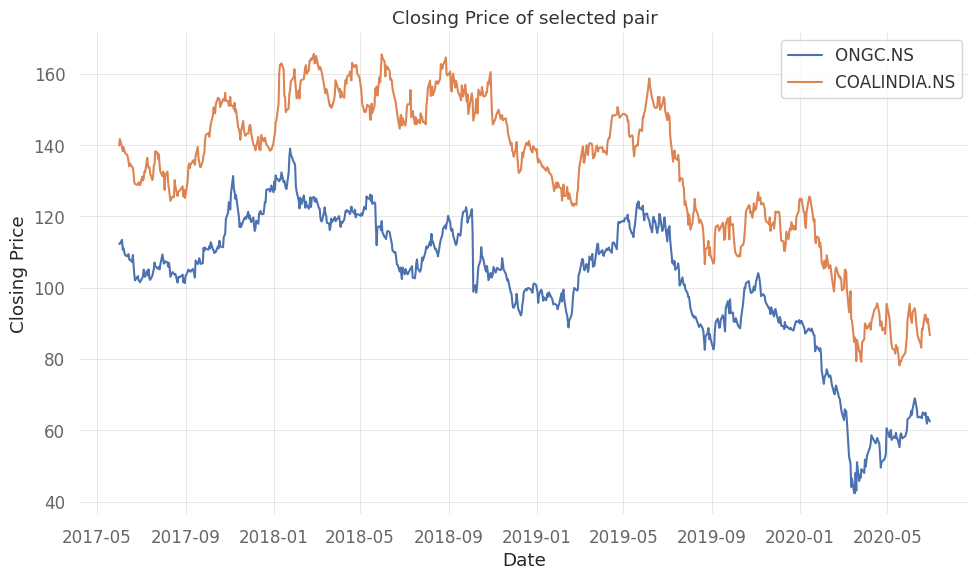

In [17]:
sns.lineplot(stock_prices[coint_pairs.iloc[0, 0]], label=coint_pairs.iloc[0, 0])
sns.lineplot(stock_prices[coint_pairs.iloc[0, 1]], label=coint_pairs.iloc[0, 1])
plt.title('Closing Price of selected pair')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Selected Pair of Stocks

In [18]:
stock1 = coint_pairs.iloc[0, 1]
stock2 = coint_pairs.iloc[0, 0]

hedge_ratio = coint_pairs.iloc[0, 4]

In [19]:
startdate = "2020-07-01"
enddate = "2024-07-31"

stockprices = yf.download([stock1, stock2], start=startdate, end=enddate)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [20]:
stockprices

Ticker,COALINDIA.NS,ONGC.NS
Date,,
2020-07-01,86.038887,61.022701
2020-07-02,85.878204,62.084625
2020-07-03,86.938797,62.501812
2020-07-06,87.324471,63.525814
2020-07-07,85.396072,62.160473
...,...,...
2024-07-24,464.679688,303.455322
2024-07-25,464.867920,318.886841
2024-07-26,479.783203,314.898407


### <font color='black'> Calculating spread

In [21]:
spread = -stockprices[stock1]*hedge_ratio + stockprices[stock2]

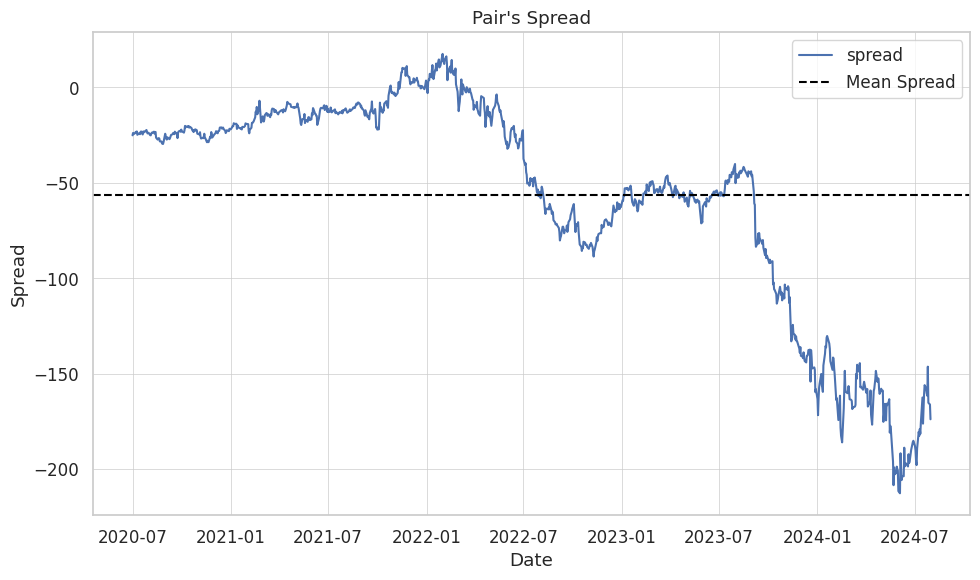

In [22]:
sns.lineplot(spread, label='spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean Spread')
plt.title("Pair's Spread")
plt.ylabel('Spread')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.legend()
plt.tight_layout()
plt.show()

### <font color='black'>Calculating z-score

In [23]:
def zscore(series):
    lookback = 14
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])

In [24]:
zscore = zscore(spread)

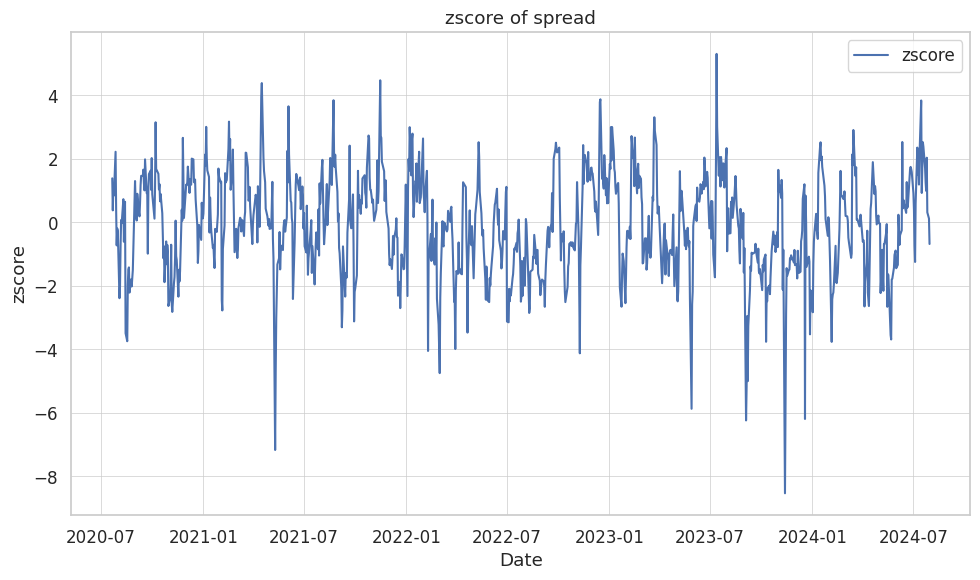

In [25]:
sns.lineplot(zscore, label = 'zscore')
plt.title("zscore of spread")
plt.ylabel('zscore')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Trading Strategy

### <font color='black'>Generation of Signals

In [26]:
# Create a dataframe for trading signals
signals = pd.DataFrame()
signals[stock1] = stockprices[stock1]
signals[stock2] = stockprices[stock2]
signals['spread'] = spread
signals['zscore'] = zscore

signals.dropna(inplace = True)

signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
signals['position1'] = 0

signals['position1'] = signals['signal1'].diff()
if signals['signal1'][0] != 0:
    signals['position1'][0] = signals['signal1'][0]
signals['signal2'] = -signals['signal1']
signals['position2'] = -signals['position1']

signals.dropna(inplace = True)
signals

,COALINDIA.NS,ONGC.NS,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2020-07-21,85.556786,62.539742,-23.093021,1.388547,1,1.0,-1,-1.0
2020-07-22,86.199600,62.653522,-23.622625,0.380019,0,-1.0,0,1.0
2020-07-23,85.781769,62.691452,-23.166493,1.092315,1,1.0,-1,-1.0
2020-07-24,84.592598,61.439892,-23.227827,0.847676,0,-1.0,0,1.0
2020-07-27,83.531952,61.288197,-22.317934,2.224997,1,1.0,-1,-1.0
...,...,...,...,...,...,...,...,...
2024-07-24,464.679688,303.455322,-161.637014,0.992584,0,-1.0,0,1.0
2024-07-25,464.867920,318.886841,-146.393895,2.037857,1,1.0,-1,-1.0
2024-07-26,479.783203,314.898407,-165.310857,0.316646,0,-1.0,0,1.0


### <font color='black'>Visualizing Long and Short Positions

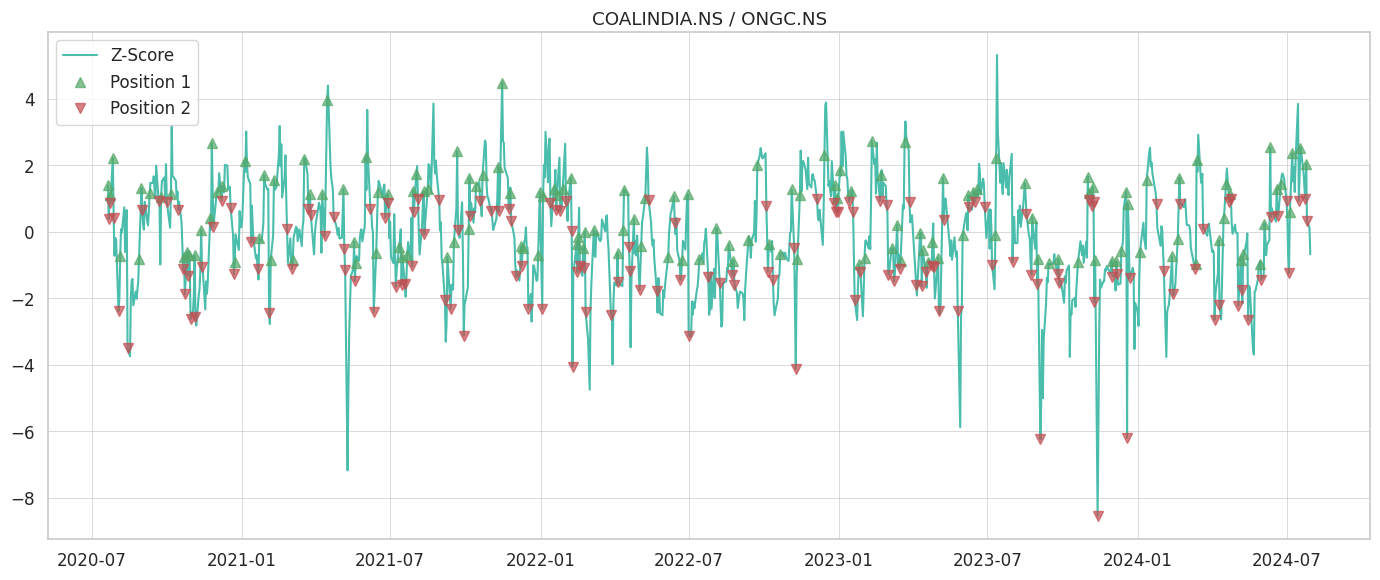

In [27]:
fig = plt.figure(figsize=(14, 6))
bx = fig.add_subplot(111)
series = bx.plot(signals['zscore'], c='#4abdac')
a = (signals['position1'] == 1) | (signals['position1'] == 2)
b = (signals['position1'] == -1) | (signals['position1'] == -2)
long = bx.plot(signals['zscore'][a], lw = 0, marker = '^', markersize = 7, c = 'g', alpha = 0.7)
short = bx.plot(signals['zscore'][b], lw = 0, marker = 'v', markersize = 7, c = 'r', alpha = 0.7)
plt.title(f'{stock1} / {stock2}')
plt.legend(['Z-Score', 'Position 1', 'Position 2'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

Position 1 --  Buy COALINDIA.NS and Sell ONGC.NS <br>
Position 2 -- Sell COALINDIA.NS and Buy ONGC.NS

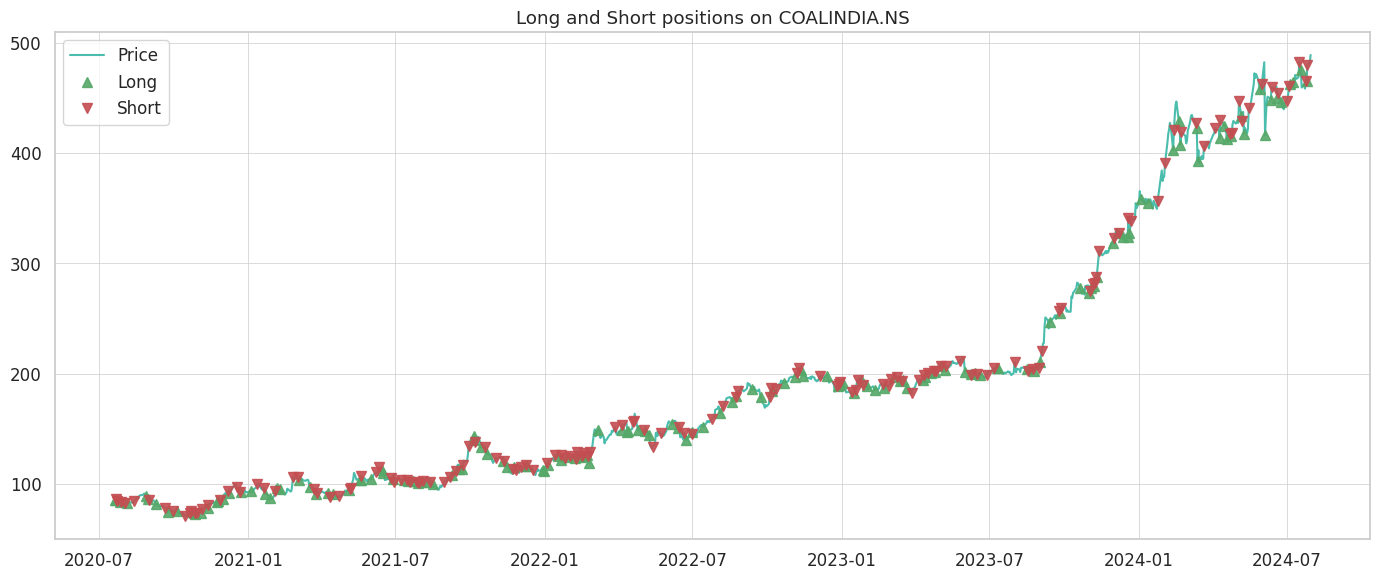

In [28]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock1], c='#4abdac')
u1 = bx.plot(signals[stock1][a], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock1][b], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock1))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

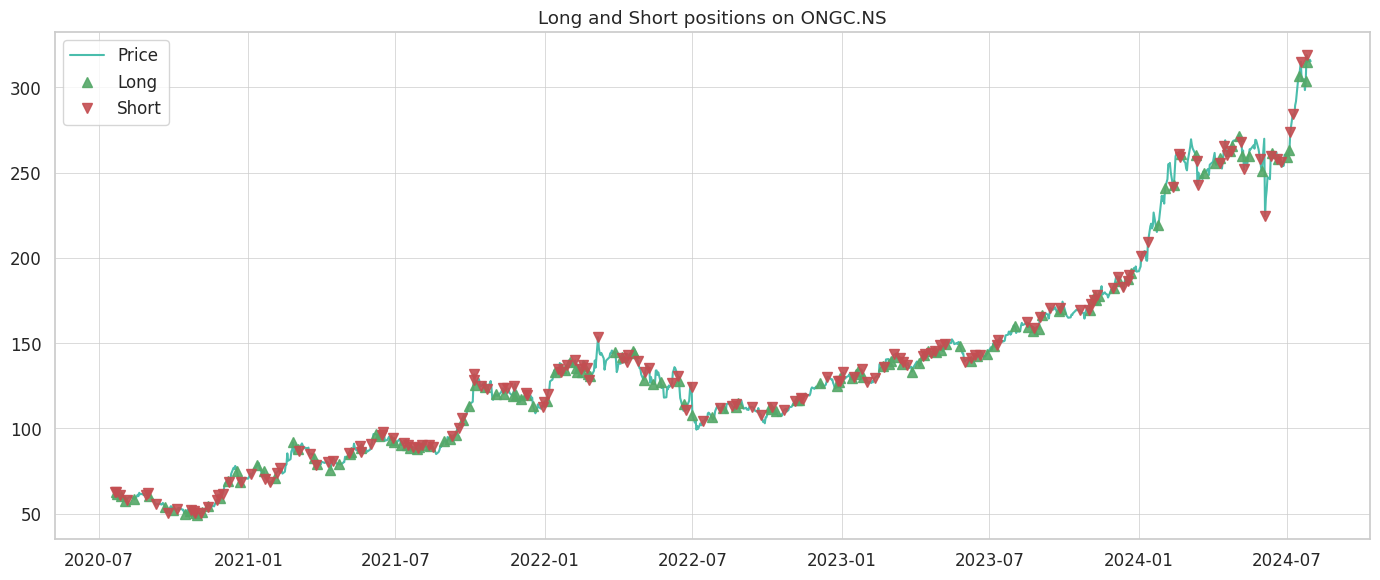

In [29]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock2], c='#4abdac')
u1 = bx.plot(signals[stock2][b], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock2][a], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock2))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Visualising daily closing prices on backtesting period

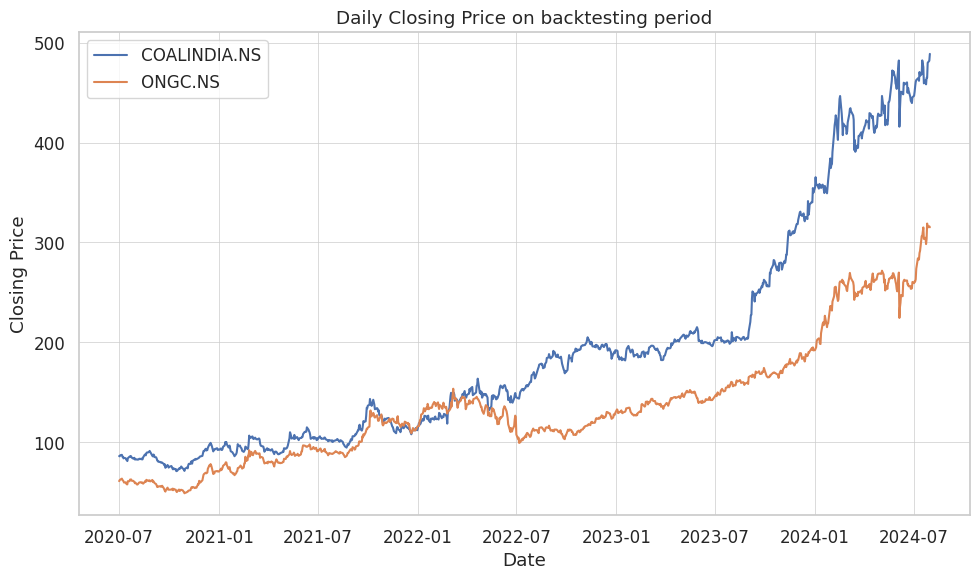

In [30]:
sns.lineplot(stockprices[stock1], label=stock1)
sns.lineplot(stockprices[stock2], label=stock2)
plt.title('Daily Closing Price on backtesting period')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Generating Portfolio

In [31]:
initial_capital = 100000

w1 = 0.5
w2 = 1 - w1

# Shares to buy for each stock
shares1 = (w1*initial_capital)// (signals[stock1][0])
shares2 = (w2*initial_capital)// (signals[stock2][0])

#PnL for stock 1
portfolio = pd.DataFrame()
portfolio['holdings1'] = signals['position1'].cumsum() * signals[stock1] * shares1
portfolio['cash1'] = w1*initial_capital - (signals['position1'] * signals[stock1] * shares1).cumsum()
portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total1'].pct_change()

# PnL for stock 2
portfolio['holdings2'] = signals['position2'].cumsum() * signals[stock2] * shares2
portfolio['cash2'] = w2*initial_capital - (signals['position2'] * signals[stock2] * shares2).cumsum()
portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total2'].pct_change()

# Total PnL
portfolio['total'] = portfolio['total1'] + portfolio['total2']
portfolio = portfolio.dropna()

In [32]:
portfolio

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-07-22,0.000000,50375.403748,50375.403748,0.007508,0.000000,49909.089001,49909.089001,-0.001818,100284.492748
2020-07-23,50096.552979,278.850769,50375.403748,0.000000,-50090.470169,99999.559170,49909.089001,0.000000,100284.492748
2020-07-24,0.000000,49680.927979,49680.927979,-0.013786,0.000000,50909.085609,50909.085609,0.020036,100590.013588
2020-07-27,48782.659912,898.268066,49680.927979,0.000000,-48969.269054,99878.354664,50909.085609,0.000000,100590.013588
2020-07-28,0.000000,49868.636536,49868.636536,0.003778,0.000000,51454.551605,51454.551605,0.010715,101323.188141
...,...,...,...,...,...,...,...,...,...
2024-07-24,0.000000,113393.669617,113393.669617,0.034079,0.000000,87466.962662,87466.962662,-0.044748,200860.632278
2024-07-25,271482.865234,-158089.195618,113393.669617,0.000000,-254790.585815,342257.548477,87466.962662,0.000000,200860.632278
2024-07-26,0.000000,122104.195007,122104.195007,0.076817,0.000000,90653.721298,90653.721298,0.036434,212757.916306


### <font color='black'>Visualizing Portfolio PnL

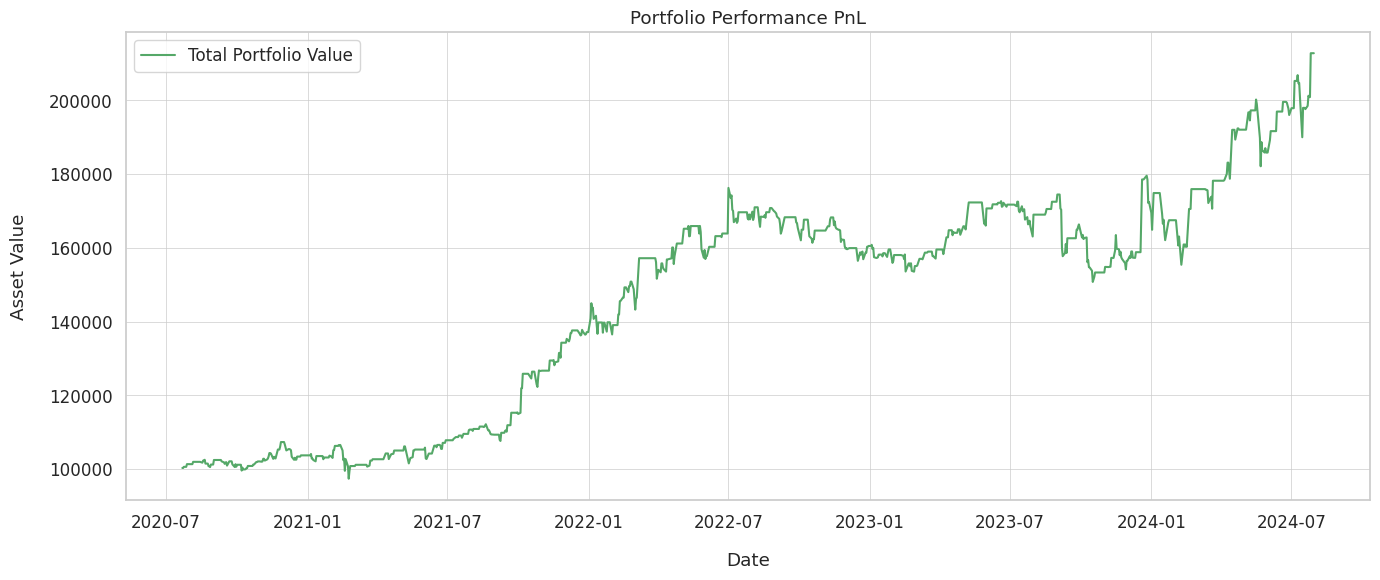

In [33]:
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
l1, = ax.plot(portfolio['total'], c='g')
ax.set_ylabel('Asset Value')
ax.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance PnL')
plt.legend(['Total Portfolio Value'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Performance Metrics of Trading Strategy on Selected Pair of Stocks

In [34]:
final_portfolio = portfolio['total'].iloc[-1]
initial_portfolio = portfolio['total'].iloc[0]
delta = len(portfolio.index)
print('Number of trading days = ', delta)
YEAR_DAYS = 252
returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

Number of trading days =  996
CAGR = 20.961%


In [35]:
cummulative_return = (final_portfolio/initial_portfolio)-1
print('Cummulative Return = {:.3f}%' .format(cummulative_return * 100))

Cummulative Return = 112.154%


In [36]:
drawdown = qs.stats.max_drawdown(portfolio['total'])
print("Maximmum Drawdown of trading strategy:", np.round(drawdown*100, 3), "%")

Maximmum Drawdown of trading strategy: -14.467 %


In [37]:
sharpe_ratio = qs.stats.sharpe(portfolio['total'])
print("Sharpe Ratio:", np.round(sharpe_ratio, 3))

Sharpe Ratio: 1.129


In [38]:
sortino_ratio = qs.stats.sortino(portfolio['total'])
print("Sortino Ratio:", np.round(sortino_ratio, 3))

Sortino Ratio: 1.85


In [39]:
print('Frequency of trades:', np.round(abs(signals['position1']).sum()/len(portfolio)*252, 3), 'per year')

Frequency of trades: 77.422 per year
